# TASK 3

### Splitting the images into new folders

In [1]:
import os
import shutil

# Paths to your original image folder and the "train" and "test" text documents
image_folder = "kvasir-instrument/images/images"
mask_folder = "kvasir-instrument/masks/masks"

train_txt = "kvasir-instrument/train.txt"  # Path to the "train" text document
test_txt = "kvasir-instrument/test.txt"  # Path to the "test" text document

# Output directories for train and test splits
train_output_dir = "train-images"
test_output_dir = "test-images"
train_mask_output_dir = "train-masks"
test_mask_output_dir = "test-masks"

# Create output directories if they don't exist
os.makedirs(train_output_dir, exist_ok=True)
os.makedirs(test_output_dir, exist_ok=True)
os.makedirs(train_mask_output_dir, exist_ok=True)
os.makedirs(test_mask_output_dir, exist_ok=True)

# Read the list of image file paths from "train.txt" and copy them to the train directory
with open(train_txt, 'r') as train_file:
    train_image_paths = train_file.read().splitlines()
    for image_path in train_image_paths:
        image_name = os.path.basename(image_path) + ".jpg"
        source_image_path = os.path.join(image_folder, image_name)
        target_image_path = os.path.join(train_output_dir, image_name)
        shutil.copyfile(source_image_path, target_image_path)
        
with open(train_txt, 'r') as train_file:
    train_image_paths = train_file.read().splitlines()
    for image_path in train_image_paths:
        image_name = os.path.basename(image_path) + ".png"
        source_mask_path = os.path.join(mask_folder, image_name)
        target_mask_path = os.path.join(train_mask_output_dir, image_name)
        shutil.copyfile(source_mask_path, target_mask_path)

# Read the list of image file paths from "test.txt" and copy them to the test directory
with open(test_txt, 'r') as test_file:
    test_image_paths = test_file.read().splitlines()
    for image_path in test_image_paths:
        image_name = os.path.basename(image_path) + ".jpg"
        source_image_path = os.path.join(image_folder, image_name)
        target_image_path = os.path.join(test_output_dir, image_name)
        shutil.copyfile(source_image_path, target_image_path)
        
with open(test_txt, 'r') as test_file:
    test_image_paths = test_file.read().splitlines()
    for image_path in test_image_paths:
        image_name = os.path.basename(image_path) + ".png"
        source_mask_path = os.path.join(mask_folder, image_name)
        target_mask_path = os.path.join(test_mask_output_dir, image_name)
        shutil.copyfile(source_mask_path, target_mask_path)

print("Train and test splits have been created.")

Train and test splits have been created.


### Installs, imports and defining

In [14]:
# Imports and installs 
!pip install matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate

In [3]:
# Defining input shape
input_shape = (256, 256, 3)

In [4]:
# Defining the scheduler
def scheduler(epoch, lr):
    if epoch % 5 == 0 and epoch != 0:
        return lr * 0.1
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Using the val_los to check if the compiling should stop. With a patience of 3.
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

### Preprocessing of data

In [5]:
# Preprocessing of the image folders (train and test). Converting the images to arrays.
def load_and_preprocess_image(path, target_size=(256, 256)):
    img = tf.keras.preprocessing.image.load_img(path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.cast(img_array, tf.float32) / 255.0  # Normalize to 0 and 1
    return img_array

def load_images_from_folder(folder, target_size=(256, 256)):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img_array = load_and_preprocess_image(img_path, target_size)
        images.append(img_array)
    return np.array(images)

# Load and preprocess images to train_images and test_images
train_images = load_images_from_folder('train-images')
test_images = load_images_from_folder('test-images')

In [6]:
# Preprocessing of the mask folders (train and test). Converting the images to arrays and making them grayscale.
def load_and_preprocess_mask(path, target_size=(256, 256)):
    mask = tf.keras.preprocessing.image.load_img(path, target_size=target_size, color_mode='grayscale')
    mask_array = tf.keras.preprocessing.image.img_to_array(mask)
    mask_array = tf.cast(mask_array, tf.float32) / 255.0  # Normalize to 0 and 1
    return mask_array

def load_masks_from_folder(folder, target_size=(256, 256)):
    masks = []
    for filename in os.listdir(folder):
        mask_path = os.path.join(folder, filename)
        mask_array = load_and_preprocess_mask(mask_path, target_size)
        masks.append(mask_array)
    return np.array(masks)

# Load and preprocess masks to train-masks and test-masks
train_masks = load_masks_from_folder('train-masks')
test_masks = load_masks_from_folder('test-masks')

### Making the models

In [7]:
# Defining the model with the ReLU activation. (Choosing the sigmoid in the output to get binary mask output)
model_ReLU = Sequential([
    Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(2, 2),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(1, (1, 1), activation='sigmoid')
])

# Compiling the ReLU model
model_ReLU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [8]:
# Defining the model with the sigmoid activation. (Choosing the sigmoid in the output to get binary mask output)
model_sigmoid = Sequential([
    Conv2D(32, (3, 3), activation='sigmoid', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='sigmoid', padding='same'),
    MaxPooling2D(2, 2),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='sigmoid', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(1, (1, 1), activation='sigmoid')
])

# Compiling the sigmoid model
model_sigmoid.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [9]:
# Defining the model with the tanh activation. (Choosing the sigmoid in the output to get binary mask output)
model_tanh = Sequential([
    Conv2D(32, (3, 3), activation='tanh', padding='same', input_shape=(256, 256, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='tanh', padding='same'),
    MaxPooling2D(2, 2),
    Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='tanh', padding='same'),
    Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'),
    Conv2D(1, (1, 1), activation='sigmoid')
])

# Compiling the tahn model
model_tanh.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Fitting the models

In [10]:
# Fitting the ReLU model, to check how it perform. Using a batch size of 32, 10 epochs and using the lr_scheduler and early_stopping defined earlier.
history_ReLU = model_ReLU.fit(
    train_images, 
    train_masks, 
    batch_size=32, 
    epochs=10, 
    validation_data=(test_images, test_masks),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
15/15 [==============================] - 43s 3s/step - loss: 0.5540 - accuracy: 0.8597 - val_loss: 0.3803 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 42s 3s/step - loss: 0.3484 - accuracy: 0.8995 - val_loss: 0.2826 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 39s 3s/step - loss: 0.2743 - accuracy: 0.8995 - val_loss: 0.2310 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 40s 3s/step - loss: 0.2171 - accuracy: 0.8995 - val_loss: 0.1635 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 39s 3s/step - loss: 0.1766 - accuracy: 0.9097 - val_loss: 0.1515 - val_accuracy: 0.9428 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - 40s 3s/step - loss: 0.1700 - accuracy: 0.9313 - val_loss: 0.1476 - val_accuracy: 0.9437 - lr: 1.0000e-04
Epoch 7/10
15/15 [==============================] - 40s 3s/step - loss: 0.1680

In [11]:
# Fitting the sigmoid model, to check how it perform. Using a batch size of 32, 10 epochs and using the lr_scheduler and early_stopping defined earlier.
history_sigmoid = model_sigmoid.fit(
    train_images, 
    train_masks, 
    batch_size=32, 
    epochs=10, 
    validation_data=(test_images, test_masks),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
15/15 [==============================] - 41s 3s/step - loss: 0.4047 - accuracy: 0.8680 - val_loss: 0.3158 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 39s 3s/step - loss: 0.3321 - accuracy: 0.8995 - val_loss: 0.3120 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 38s 3s/step - loss: 0.3290 - accuracy: 0.8995 - val_loss: 0.3123 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 39s 3s/step - loss: 0.3281 - accuracy: 0.8995 - val_loss: 0.3113 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 38s 3s/step - loss: 0.3276 - accuracy: 0.8995 - val_loss: 0.3107 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - 39s 3s/step - loss: 0.3274 - accuracy: 0.8995 - val_loss: 0.3108 - val_accuracy: 0.9068 - lr: 1.0000e-04
Epoch 7/10
15/15 [==============================] - 41s 3s/step - loss: 0.3272

In [12]:
# Fitting the tahn model, to check how it perform. Using a batch size of 32, 10 epochs and using the lr_scheduler and early_stopping defined earlier.
history_tanh = model_tanh.fit(
    train_images, 
    train_masks, 
    batch_size=32, 
    epochs=10, 
    validation_data=(test_images, test_masks),
    callbacks=[lr_scheduler, early_stopping]
)

Epoch 1/10
15/15 [==============================] - 42s 3s/step - loss: 0.4644 - accuracy: 0.8716 - val_loss: 0.3387 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 2/10
15/15 [==============================] - 39s 3s/step - loss: 0.3418 - accuracy: 0.8995 - val_loss: 0.3139 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 3/10
15/15 [==============================] - 38s 3s/step - loss: 0.3233 - accuracy: 0.8995 - val_loss: 0.2974 - val_accuracy: 0.9068 - lr: 0.0010
Epoch 4/10
15/15 [==============================] - 38s 3s/step - loss: 0.2965 - accuracy: 0.8994 - val_loss: 0.2548 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 5/10
15/15 [==============================] - 38s 3s/step - loss: 0.2431 - accuracy: 0.9051 - val_loss: 0.2272 - val_accuracy: 0.9071 - lr: 0.0010
Epoch 6/10
15/15 [==============================] - 38s 3s/step - loss: 0.2246 - accuracy: 0.9040 - val_loss: 0.1998 - val_accuracy: 0.9215 - lr: 1.0000e-04
Epoch 7/10
15/15 [==============================] - 38s 3s/step - loss: 0.2125

In [21]:
def plot_model_performance(history, model_name, metric='accuracy'):
    plt.plot(history.history[metric], label=f'Train {metric} - {model_name}')
    plt.plot(history.history[f'val_{metric}'], label=f'Validation {metric} - {model_name}')
    plt.title(f'Model {metric} - {model_name}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

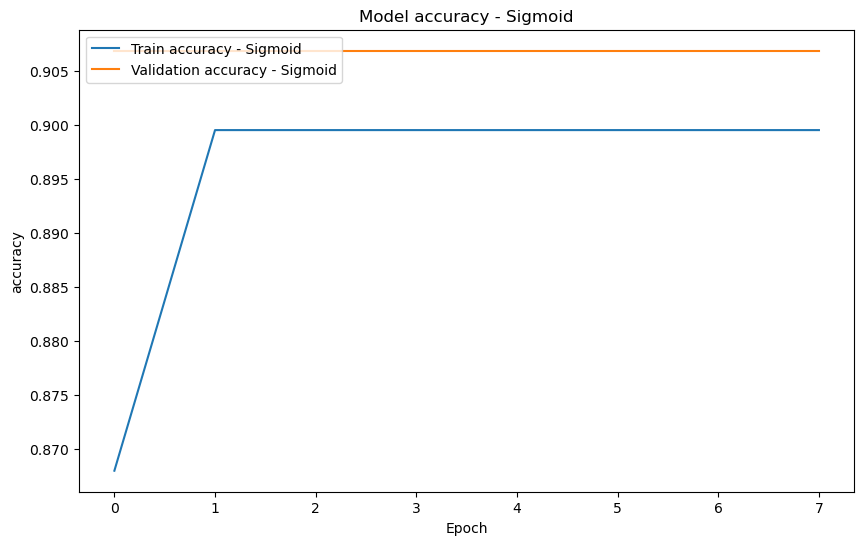

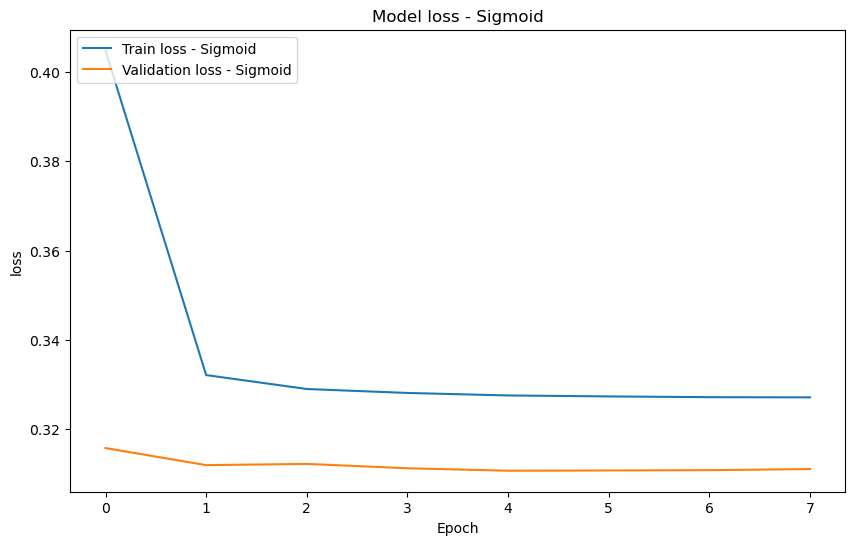

In [22]:
plt.figure(figsize=(10, 6))
plot_model_performance(history_sigmoid, 'Sigmoid', 'accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_model_performance(history_sigmoid, 'Sigmoid', 'loss')
plt.show()

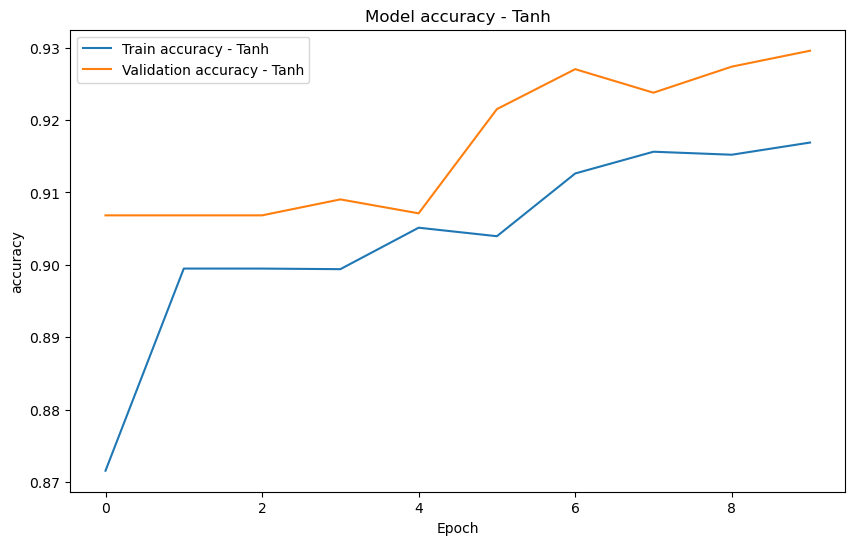

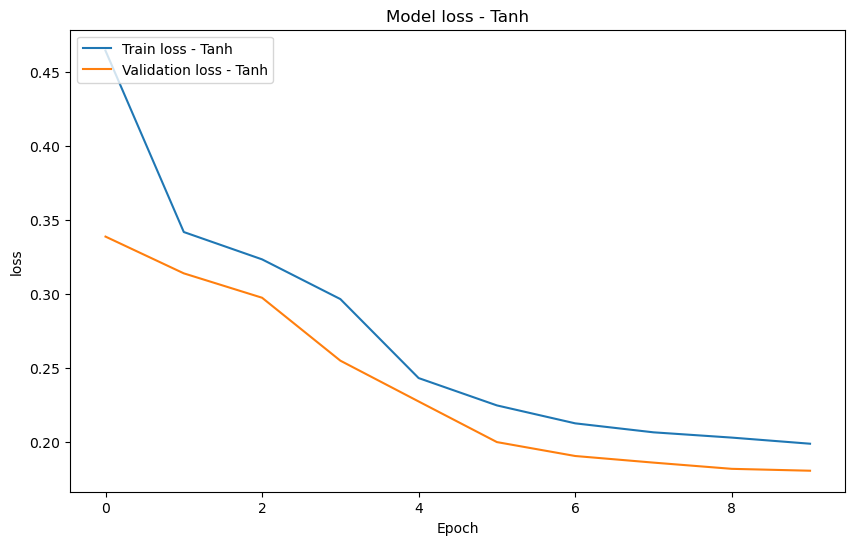

In [23]:
plt.figure(figsize=(10, 6))
plot_model_performance(history_tanh, 'Tanh', 'accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_model_performance(history_tanh, 'Tanh', 'loss')
plt.show()

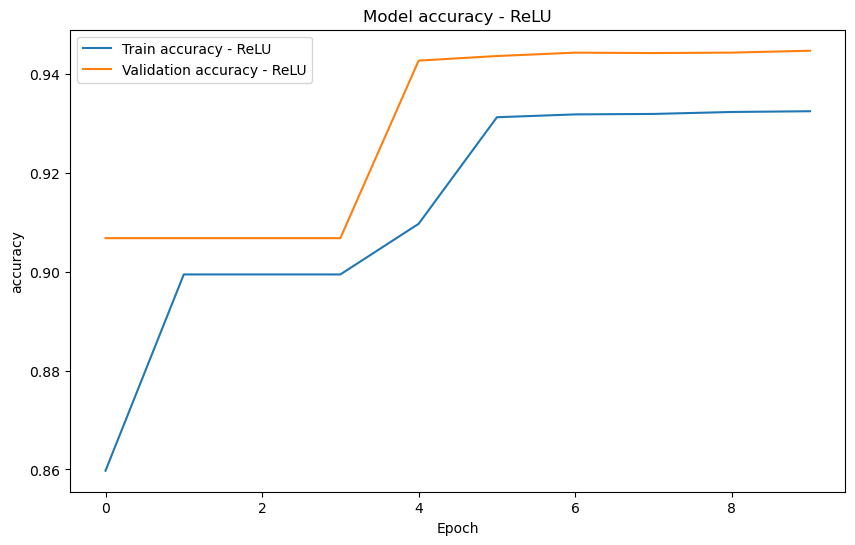

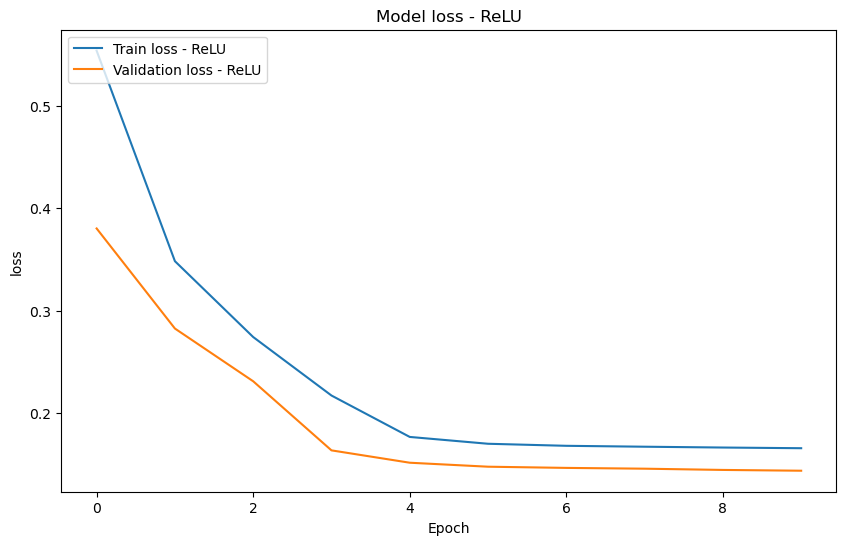

In [24]:
plt.figure(figsize=(10, 6))
plot_model_performance(history_ReLU, 'ReLU', 'accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plot_model_performance(history_ReLU, 'ReLU', 'loss')
plt.show()